In [1]:
import pandas as pd
import math
import numpy as np
import gensim
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud

data = pd.read_csv('strategies_final.csv')

In [2]:
import re
from tqdm import tqdm

def text_standardize(text):
    """
    fixes some issues the spacy tokenizer had on books corpus
    also does some whitespace standardization
    """
    text = text.replace('—', '-')
    text = text.replace('–', '-')
    text = text.replace('―', '-')
    text = text.replace('…', '...')
    text = text.replace('\\n', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('´', "'")
    text = re.sub(r'''(-+|~+|!+|"+|;+|\?+|\++|,+|\)+|\(+|\\+|\/+|\*+|\[+|\]+|}+|{+|\|+|_+)''', r' \1 ', text)
    text = re.sub(r'\s*\n\s*', ' \n ', text)
    text = re.sub(r'[^\S\n]+', ' ', text)
    return text.strip()


def normalize_text(text, lower=True):
    text = str(text)
    text = text_standardize(text)
    if lower:
        text = text.lower()
    return ' '.join(filter(None, (''.join(c for c in w if c.isalnum())
                                  for w in text.split())))

In [3]:
data1 = data[data['period']=='pre-covid']
data2 = data[data['period']=='intra-covid']

In [4]:
abstract1 = [normalize_text(i) for i in tqdm(data1.text_clean)]
abstract2 = [normalize_text(i) for i in tqdm(data2.text_clean)]

100%|██████████| 160/160 [00:09<00:00, 17.37it/s]


In [5]:
exclude_punc = '!"#$%&\'()*+,-.。/:;<=>?@[\\]^_`{|}~、，；：「」【】→□'

# English stop words should be more
stopwords = set(['very', 'ourselves', 'am', 'doesn', 'through', 'me', 'against', 'up', 'just', 'her', 'ours', 
            'couldn', 'because', 'is', 'isn', 'it', 'only', 'in', 'such', 'too', 'mustn', 'under', 'their', 
            'if', 'to', 'my', 'himself', 'after', 'why', 'while', 'can', 'each', 'itself', 'his', 'all', 'once', 
            'herself', 'more', 'our', 'they', 'hasn', 'on', 'ma', 'them', 'its', 'where', 'did', 'll', 'you', 
            'didn', 'nor', 'as', 'now', 'before', 'those', 'yours', 'from', 'who', 'was', 'm', 'been', 'will', 
            'into', 'same', 'how', 'some', 'of', 'out', 'with', 's', 'being', 't', 'mightn', 'she', 'again', 'be', 
            'by', 'shan', 'have', 'yourselves', 'needn', 'and', 'are', 'o', 'these', 'further', 'most', 'yourself', 
            'having', 'aren', 'here', 'he', 'were', 'but', 'this', 'myself', 'own', 'we', 'so', 'i', 'does', 'both', 
            'when', 'between', 'd', 'had', 'the', 'y', 'has', 'down', 'off', 'than', 'haven', 'whom', 'wouldn', 
            'should', 've', 'over', 'themselves', 'few', 'then', 'hadn', 'what', 'until', 'won', 'no', 'about', 
            'any', 'that', 'for', 'shouldn', 'don', 'do', 'there', 'doing', 'an', 'or', 'ain', 'hers', 'wasn', 
            'weren', 'above', 'a', 'at', 'your', 'theirs', 'below', 'other', 'not', 're', 'him', 'during', 'which'])


def clean(doc):
    stop_free = [word for word in doc if word not in stopwords]
    punc_free = [word for word in stop_free if word not in exclude_punc]
    return punc_free

abstract1_cleaned = [i.split() for i in tqdm(abstract1)]
abstract1_cleaned = [clean(i) for i in tqdm(abstract1_cleaned)]

abstract2_cleaned = [i.split() for i in tqdm(abstract2)]
abstract2_cleaned = [clean(i) for i in tqdm(abstract2_cleaned)]


#generate dic

import gensim

dictionary1 = gensim.corpora.Dictionary(abstract1_cleaned)
doc_term_matrix1 = [dictionary1.doc2bow(doc) for doc in abstract1_cleaned]

dictionary2 = gensim.corpora.Dictionary(abstract2_cleaned)
doc_term_matrix2 = [dictionary2.doc2bow(doc) for doc in abstract2_cleaned]



100%|██████████| 160/160 [00:00<00:00, 395.95it/s]


In [6]:
model1 = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix1, num_topics=14, id2word=dictionary1, passes=10)
model2 = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix2, num_topics=14, id2word=dictionary2, passes=10)

In [7]:
font = r'/System/Library/fonts/Times.ttc'

<ipython-input-9-cfb93b2af748>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


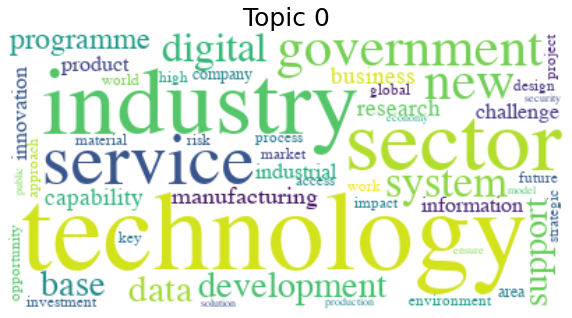

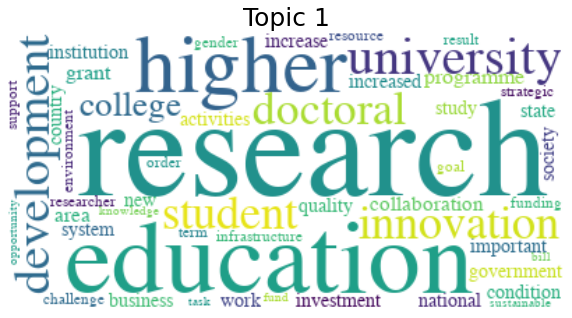

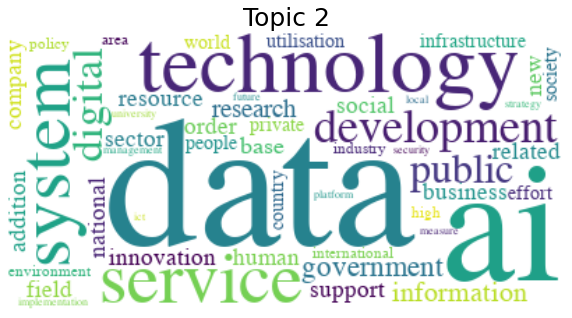

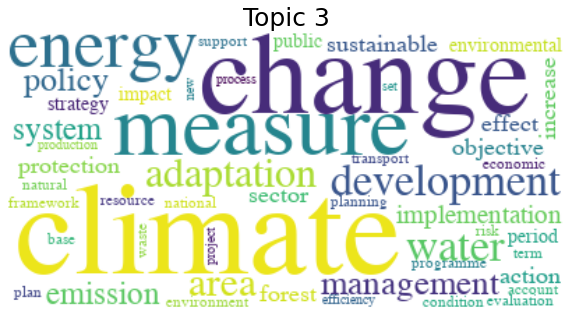

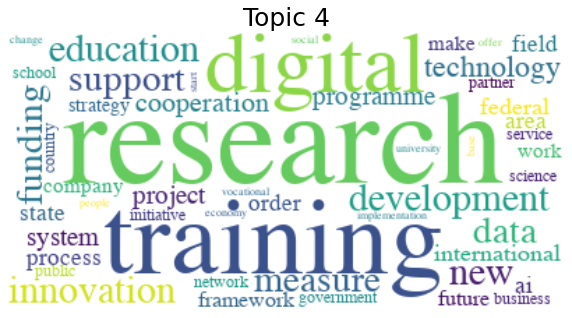

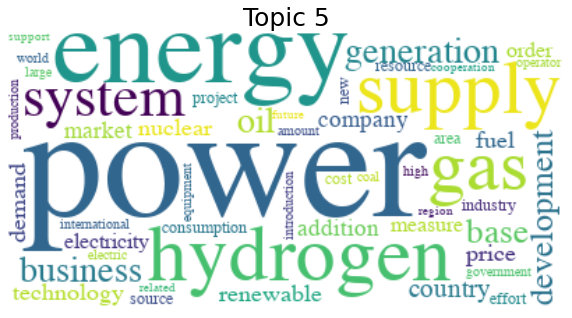

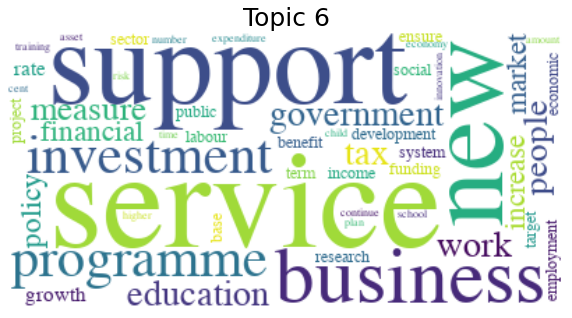

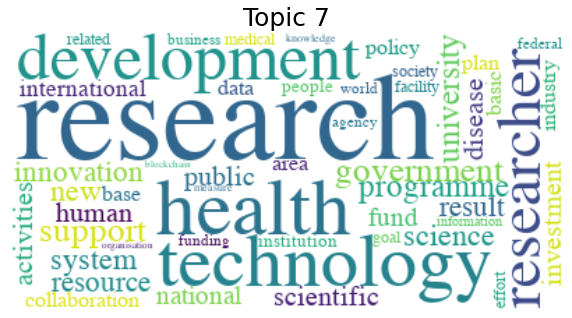

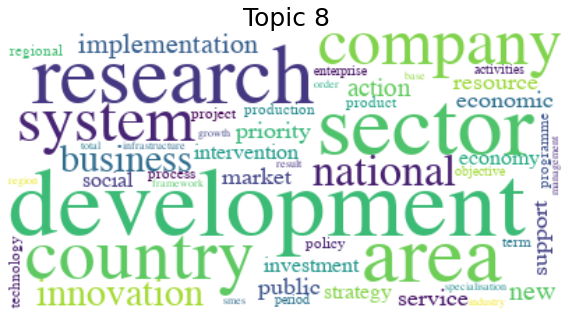

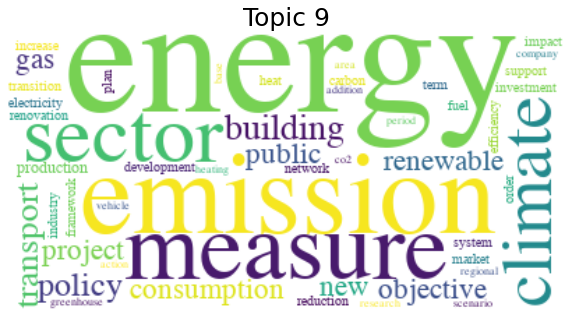

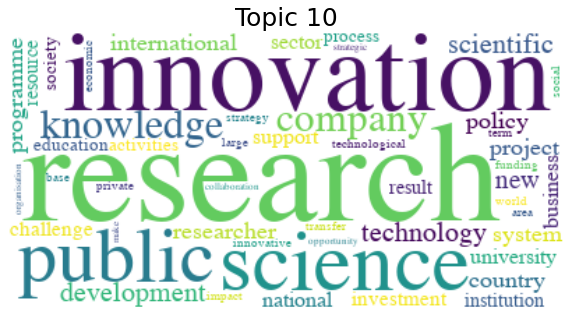

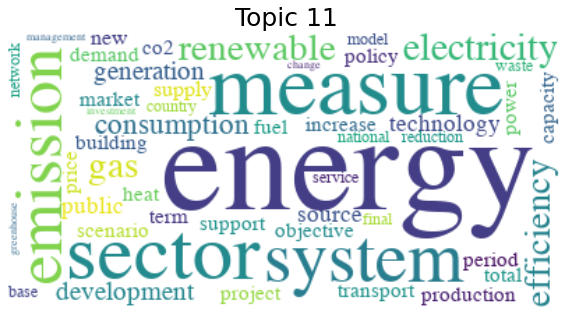

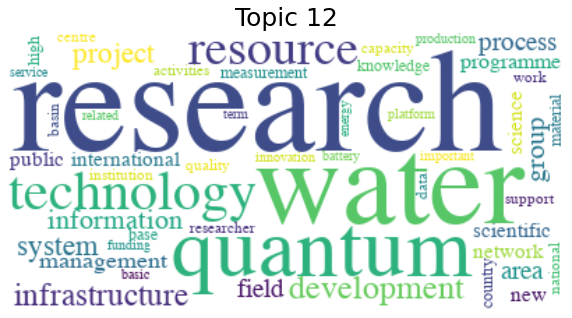

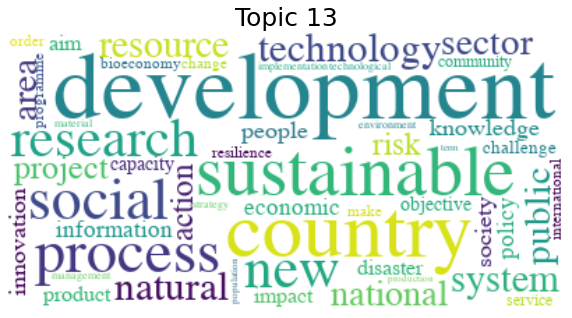

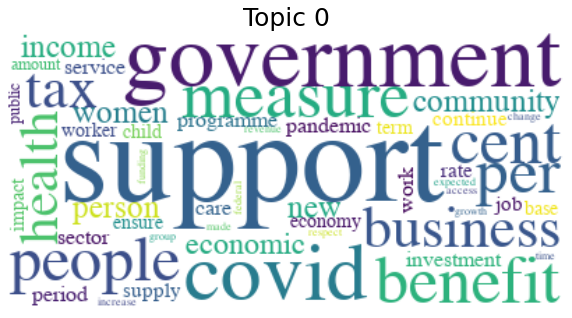

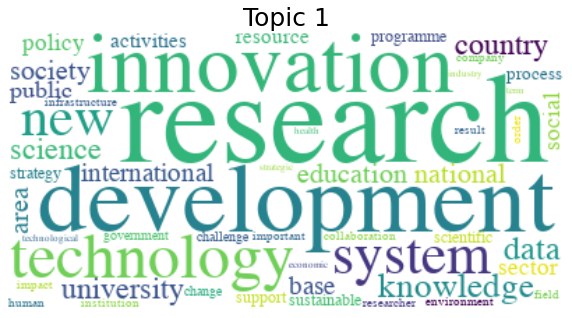

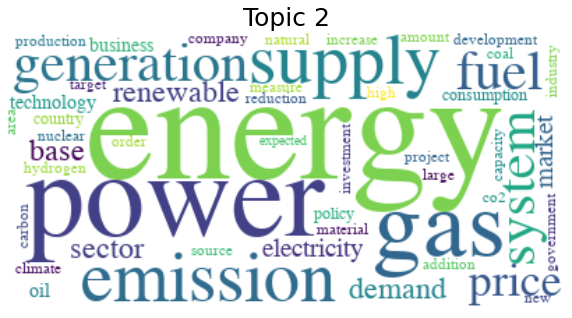

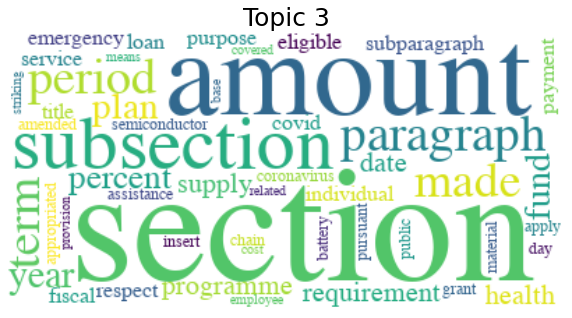

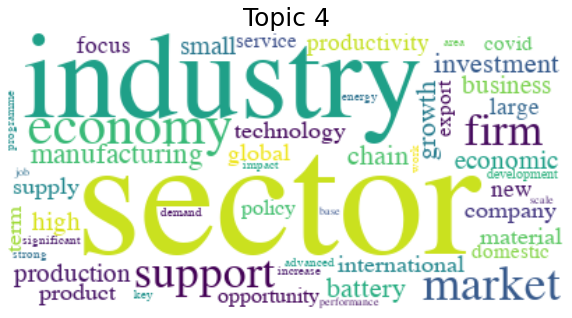

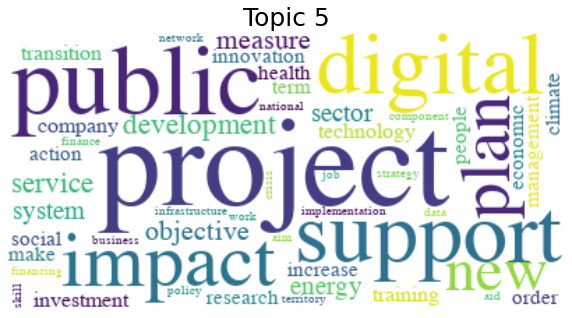

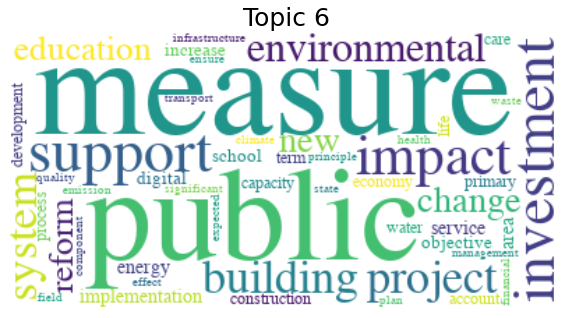

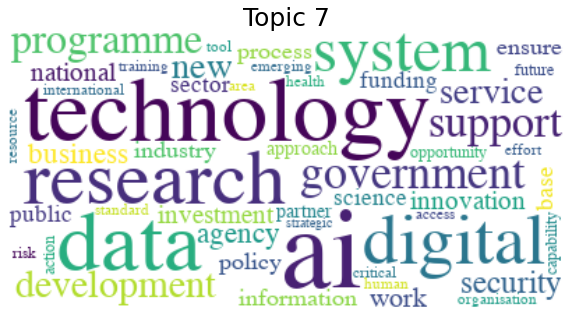

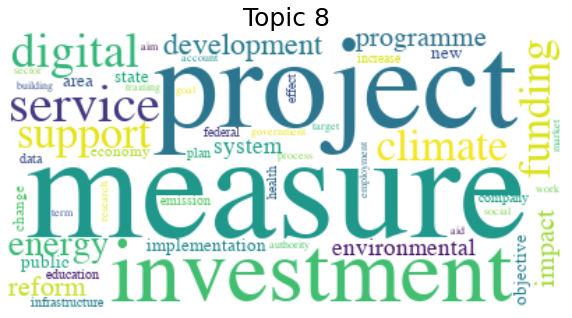

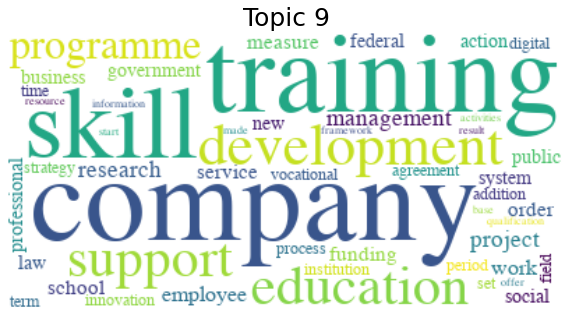

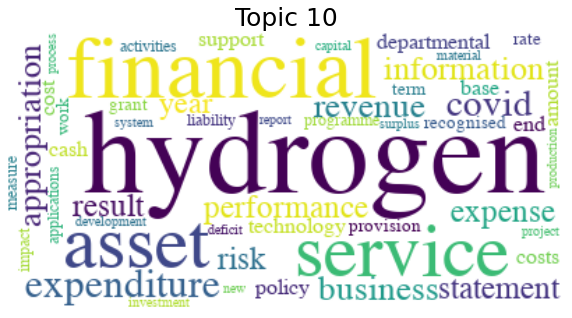

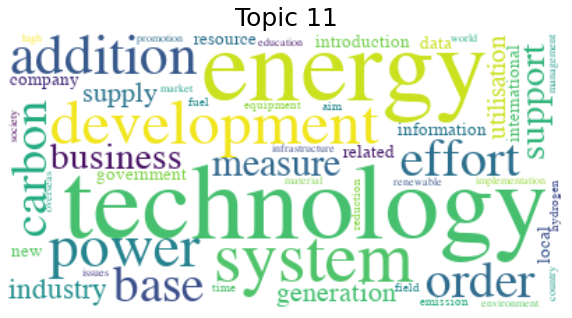

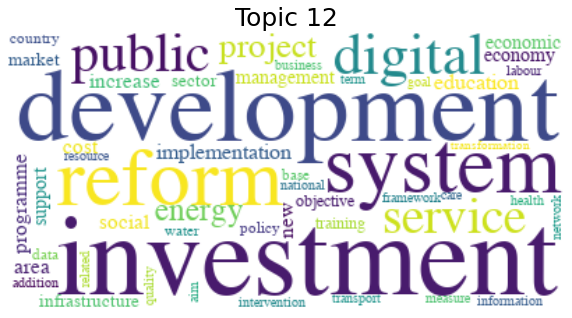

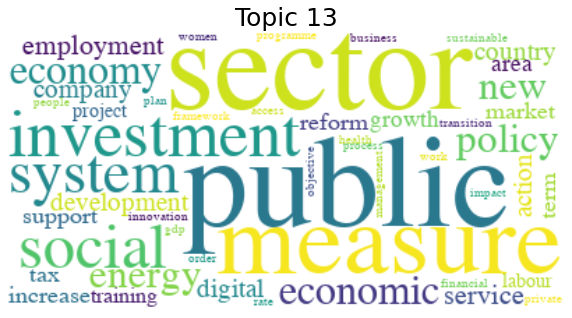

In [9]:
for i in range(14):
    plt.figure(figsize=(10,10))
    plt.imshow(WordCloud(max_words=50, font_path=font, background_color='white').
               fit_words(dict(model1.show_topic(i, 200))), interpolation='bilinear')
    plt.axis('off')
    plt.title('Topic ' + str(i),fontdict=dict(size=25))
    plt.savefig('/Users/zqh/Documents/OECD/code/wordcloud/covid/pre/word_cloud_topic_'+ str(i) +'.png', bbox_inches='tight')
    
for i in range(14):
    plt.figure(figsize=(10,10))
    plt.imshow(WordCloud(max_words=50, font_path=font, background_color='white').
               fit_words(dict(model2.show_topic(i, 200))), interpolation='bilinear')
    plt.axis('off')
    plt.title('Topic ' + str(i),fontdict=dict(size=25))
    plt.savefig('/Users/zqh/Documents/OECD/code/wordcloud/covid/intra/word_cloud_topic_'+ str(i) +'.png', bbox_inches='tight')